In [ ]:
import sys

sys.path.append('..')

In [10]:
import cloudpickle
import geopandas as gpd
from scipy.sparse import load_npz
from modeling_lanternfly_populations.config import MODELS_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [16]:
mrf_folder = MODELS_DIR / 'mrf'
grid_size = 1.0
gdf = gpd.read_parquet(INTERIM_DATA_DIR / '1.0_deg_lanternfly.parquet')
neighbors = load_npz(INTERIM_DATA_DIR / '1.0_neighbors.npz').toarray()
inference_data = az.from_netcdf(mrf_folder / f'{grid_size}_mrf_posterior.nc')

with open(mrf_folder / f'{grid_size}_mrf_model_params.pkl', 'rb') as file:
    model = cloudpickle.load(file)



In [14]:
model

  lambda ~ Gamma(1, f())
   sigma ~ HalfNormal(0, 1)
   obs_0 ~ Normal(0, sigma)
   obs_1 ~ Normal(0, sigma)
   obs_2 ~ Normal(0, sigma)
   obs_3 ~ Normal(0, sigma)
   obs_4 ~ Normal(0, sigma)
   obs_5 ~ Normal(0, sigma)
   obs_6 ~ Normal(0, sigma)
   obs_7 ~ Normal(0, sigma)
   obs_8 ~ Normal(0, sigma)
   obs_9 ~ Normal(0, sigma)
  obs_10 ~ Normal(0, sigma)
  obs_11 ~ Normal(0, sigma)
  obs_12 ~ Normal(0, sigma)
  obs_13 ~ Normal(0, sigma)
  obs_14 ~ Normal(0, sigma)
  obs_15 ~ Normal(0, sigma)
  obs_16 ~ Normal(0, sigma)
  obs_17 ~ Normal(0, sigma)
  obs_18 ~ Normal(0, sigma)
  obs_19 ~ Normal(0, sigma)
  obs_20 ~ Normal(0, sigma)
  obs_21 ~ Normal(0, sigma)
  obs_22 ~ Normal(0, sigma)
  obs_23 ~ Normal(0, sigma)
  obs_24 ~ Normal(0, sigma)
  obs_25 ~ Normal(0, sigma)
  obs_26 ~ Normal(0, sigma)
  obs_27 ~ Normal(0, sigma)
  obs_28 ~ Normal(0, sigma)
  obs_29 ~ Normal(0, sigma)
  obs_30 ~ Normal(0, sigma)
  obs_31 ~ Normal(0, sigma)
  obs_32 ~ Normal(0, sigma)
  obs_33 ~ Normal(0, si

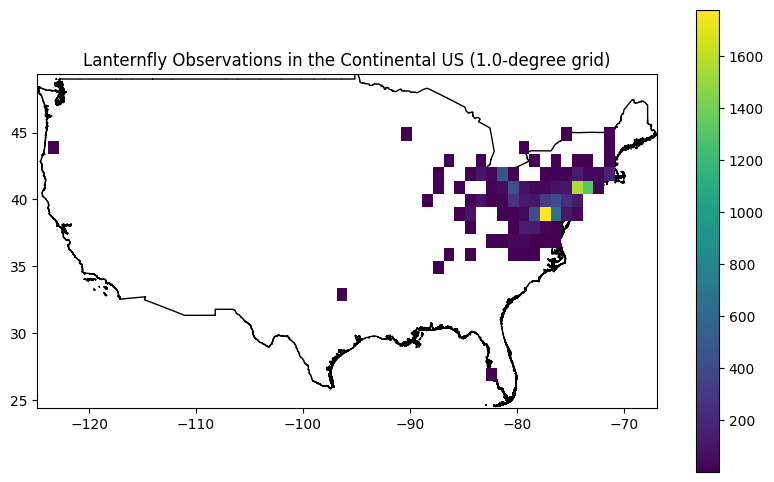

In [13]:
MIN_LON, MIN_LAT = -124.848974, 24.396308   # Southwest corner
MAX_LON, MAX_LAT = -66.885444, 49.384358    # Northeast corner
gadm_path = EXTERNAL_DATA_DIR / 'gadm41_USA_shp/gadm41_USA_0.shp'
# Read the GADM level-0 boundary
usa_admin = gpd.read_file(gadm_path)

# Make sure everything is in the same CRS, e.g., EPSG:4326
# (If your GADM is in a different CRS, reproject it)
if usa_admin.crs != 'EPSG:4326':
    usa_admin = usa_admin.to_crs('EPSG:4326')

if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')

try:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plot the grid, coloring by observation count
    usa_admin.plot(
    ax=ax,
    edgecolor='black',
    facecolor='none'
    )
    gdf.plot(
        column='observation_count',
        legend=True,
        figsize=(10, 6),
        ax=ax,
    )
    # gdf.plot(ax=ax, marker='o', markersize=5, alpha=0.5)
    plt.xlim(MIN_LON, MAX_LON)
    plt.ylim(MIN_LAT, MAX_LAT)
    plt.title("Lanternfly Observations in the Continental US (1.0-degree grid)")
    plt.show()

except ImportError:
    print("Install matplotlib to visualize results: pip install matplotlib")

In [18]:
# Assuming you have already sampled your model and saved as `inference_data`
# You can load it if necessary:

# Get the posterior predictive samples
posterior_predictive = pm.sample_posterior_predictive(inference_data.posterior, model=model, var_names=["population_count"])

# Extract the posterior predictive samples (synthetic data)
y_pred = posterior_predictive["obs"]  # Shape: (samples, chains, cells)

# Calculate summary statistics for the posterior predictive samples
y_pred_mean = y_pred.mean(axis=(0, 1))  # Mean across chains and samples
y_pred_lower = np.percentile(y_pred, 2.5, axis=(0, 1))  # 2.5th percentile for 95% CI
y_pred_upper = np.percentile(y_pred, 97.5, axis=(0, 1))  # 97.5th percentile for 95% CI

# Plot posterior predictive check (for each grid cell)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the observed values as a scatter plot
ax.scatter(gdf.geometry.x, gdf.geometry.y, c=gdf['counts'], cmap='viridis', label='Observed Population Counts')

# Overlay the posterior predictive mean and uncertainty bounds
ax.scatter(gdf.geometry.x, gdf.geometry.y, c=y_pred_mean, cmap='coolwarm', marker='x', s=100, label='Posterior Predictive Mean')

# Add confidence intervals as error bars (95% CI)
for i, (lower, upper) in enumerate(zip(y_pred_lower, y_pred_upper)):
    ax.plot([gdf.geometry.x.iloc[i], gdf.geometry.x.iloc[i]], [lower, upper], color='black', lw=1)

# Add legend and labels
ax.set_title("Posterior Predictive Check: Observed vs. Predicted Population Counts", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.legend()

# Show the plot
plt.show()

# Evaluate model fit with a simple summary of the posterior predictive distribution
observed_mean = gdf['counts'].values
predicted_mean = y_pred_mean

# Compare the observed mean to the predicted mean (you could also compare other statistics)
print("Observed Mean Population Counts:", np.mean(observed_mean))
print("Posterior Predictive Mean Population Counts:", np.mean(predicted_mean))

# You can also check for discrepancies using other metrics (e.g., RMSE, correlation, etc.)
rmse = np.sqrt(((observed_mean - predicted_mean) ** 2).mean())
print(f"RMSE between observed and posterior predictive means: {rmse:.4f}")


KeyError: 'population_count'